## Introduction
In this notebook we will demonstrates how to accelerate TensorFlow Keras applications on training workloads with BigDL-Nano.

### Prepare Environment
Before you start with Apis delivered by bigdl-nano, you have to make sure BigDL-Nano is correctly installed for TensorFlow. If not, please follow [this](../../../../../docs/readthedocs/source/doc/Nano/Overview/nano.md) to set up your environment.

The optimizations in BigDL-Nano are delivered through BigDL-Nano’s `Model` and `Sequential` classes. For most cases, you can just replace your `tf.keras.Model` to `bigdl.nano.tf.keras.Model` and `tf.keras.Sequential` to `bigdl.nano.tf.keras.Sequential` to benefits from BigDL-Nano.

In [1]:
from bigdl.nano.tf.keras import Model, Sequential

### Load Stanford Dogs Dataset
Here we load data from tensorflow_datasets(hereafter TFDS). The dataset contains images of 120 breeds of dogs around the world. There are 20,580 images, out of which 12,000 are used for training and 8580 for testing.

In [2]:
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    data_dir="../data/",
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)


/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-20 19:27:48.102563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Visualizing the data
The following code shows the first 6 images with their labels.

image  label
0  [[[14, 14, 14], [14, 14, 14], [14, 14, 14], [1...     36
1  [[[26, 25, 30], [25, 24, 29], [24, 23, 28], [2...    118
2  [[[110, 131, 114], [107, 128, 109], [113, 130,...     46
3  [[[129, 139, 140], [129, 139, 140], [130, 140,...    103
4  [[[252, 252, 252], [253, 253, 253], [253, 253,...    113
5  [[[177, 191, 132], [134, 148, 89], [219, 233, ...    116
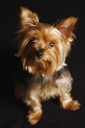
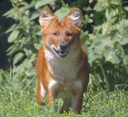
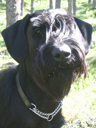
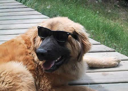
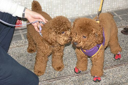
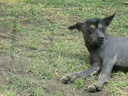

In [3]:
tfds.as_dataframe(ds_train.take(6), ds_info)

### Prepare inputs
When the dataset include images with various size, we need to resize them into a shared size. The labels are put into one-hot. The dataset is batched.

In [4]:
import tensorflow as tf
img_size = 224
num_classes = ds_info.features['label'].num_classes
batch_size = 64
def preprocessing(img, label):
    return tf.image.resize(img, (img_size, img_size)), tf.one_hot(label, num_classes)
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().repeat().shuffle(1000).map(preprocessing).batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
ds_test = ds_test.map(preprocessing).batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)

### Build Model
BigDL-Nano's `Model` and `Sequential` classes have identical APIs with `tf.keras.Model` and `tf.keras.Sequential`.
Here we initialize the model with pre-trained ImageNet weights, and we fine-tune it on the Stanford Dogs dataset. We use the `data_augmentation` preprocessor and make it part of the model.

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
data_augmentation = Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ])
def make_model(learning_rate=1e-2):
    inputs = layers.Input(shape = (img_size, img_size, 3))

    x = data_augmentation(inputs)
    backbone = EfficientNetB0(include_top=False, input_tensor=x)

    backbone.trainable = False

    x = layers.GlobalAveragePooling2D(name='avg_pool')(backbone.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = Model(inputs, outputs, name='EfficientNet')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy']
    )
    return model

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy']
    )

### Training

In [7]:
from time import time
steps_per_epoch = ds_info.splits['train'].num_examples // batch_size
model_default = make_model()

start = time()
model_default.fit(ds_train,
                  epochs=15,
                  validation_data=ds_test,
                  steps_per_epoch=steps_per_epoch)
unfreeze_model(model_default)
his_default = model_default.fit(ds_train,
                                epochs=10,
                                validation_data=ds_test,
                                steps_per_epoch=steps_per_epoch)
fit_time_default = time() - start

Epoch 1/15


187/187 [==============================] - 105s 522ms/step - loss: 3.2653 - accuracy: 0.4210 - val_loss: 0.8780 - val_accuracy: 0.7365
Epoch 2/15
187/187 [==============================] - 96s 512ms/step - loss: 1.6606 - accuracy: 0.5733 - val_loss: 0.7297 - val_accuracy: 0.7740
Epoch 3/15
187/187 [==============================] - 97s 518ms/step - loss: 1.3752 - accuracy: 0.6175 - val_loss: 0.7008 - val_accuracy: 0.7879
Epoch 4/15
187/187 [==============================] - 96s 516ms/step - loss: 1.2469 - accuracy: 0.6414 - val_loss: 0.6423 - val_accuracy: 0.8024
Epoch 5/15
187/187 [==============================] - 98s 523ms/step - loss: 1.2054 - accuracy: 0.6573 - val_loss: 0.6504 - val_accuracy: 0.8061
Epoch 6/15
187/187 [==============================] - 97s 518ms/step - loss: 1.1841 - accuracy: 0.6649 - val_loss: 0.7245 - val_accuracy: 0.7892
Epoch 7/15
187/187 [==============================] - 97s 518ms/step - loss: 1.1533 - accuracy: 0.6694 - val_loss: 0.6900 - val_accuracy: 0.

187/187 [==============================] - 113s 564ms/step - loss: 0.8553 - accuracy: 0.7457 - val_loss: 0.6118 - val_accuracy: 0.8190
Epoch 2/10
187/187 [==============================] - 105s 560ms/step - loss: 0.7349 - accuracy: 0.7700 - val_loss: 0.6196 - val_accuracy: 0.8187
Epoch 3/10
187/187 [==============================] - 105s 560ms/step - loss: 0.6721 - accuracy: 0.7948 - val_loss: 0.6293 - val_accuracy: 0.8175
Epoch 4/10
187/187 [==============================] - 104s 557ms/step - loss: 0.6426 - accuracy: 0.7980 - val_loss: 0.6197 - val_accuracy: 0.8219
Epoch 5/10
187/187 [==============================] - 104s 555ms/step - loss: 0.6037 - accuracy: 0.8141 - val_loss: 0.6292 - val_accuracy: 0.8203
Epoch 6/10
187/187 [==============================] - 103s 553ms/step - loss: 0.5785 - accuracy: 0.8183 - val_loss: 0.6229 - val_accuracy: 0.8187
Epoch 7/10
187/187 [==============================] - 103s 553ms/step - loss: 0.5542 - accuracy: 0.8278 - val_loss: 0.6278 - val_accura

#### Multi-Instance Training
BigDL-Nano makes it very easy to conduct multi-instance training correctly. You can just set the `num_processes` parameter in the `fit` method in your `Model` or `Sequential` object and BigDL-Nano will launch the specific number of processes to perform data-parallel training.

In [14]:
model_multi = make_model()

start = time()
model_multi.fit(ds_train,
                epochs=15, 
                validation_data=ds_test, 
                steps_per_epoch=steps_per_epoch,
                num_processes=4, 
                backend='multiprocessing')
unfreeze_model(model_multi)
his_multi = model_multi.fit(ds_train,
                epochs=10,
                validation_data=ds_test, 
                steps_per_epoch=steps_per_epoch,
                num_processes=4, 
                backend='multiprocessing')
fit_time_multi = time() - start


INFO:tensorflow:Assets written to: /tmp/tmptu4jfixg/temp_model/assets


INFO:tensorflow:Assets written to: /tmp/tmptu4jfixg/temp_model/assets
2022-07-20 20:44:23.761132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 20:44:23.773855: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> localhost:42225, 1 -> localhost:56035, 2 -> localhost:33729, 3 -> localhost:46359}
2022-07-20 20:44:23.774024: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> localhost:42225, 1 -> localhost:56035, 2 -> localhost:33729, 3 -> localhost:46359}
2022-07-20 20:44:23.775563: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:438] Started server with ta

Epoch 1/15


tcmalloc: large alloc 1073741824 bytes == 0x555956020000 @  0x7f874fa67d3f 0x7f874fa9e0c0 0x7f874faa1082 0x7f874faa1243 0x7f874b91e6ec 0x7f873eefab00 0x7f873eef7f39 0x7f873eef9b82 0x7f873eefa119 0x7f873eefa7bd 0x7f873dbbbfc3 0x7f8735e3764c 0x7f8735c59c6d 0x7f87359ac9d2 0x7f87359ad200 0x7f87359ad3d5 0x7f8742d0b163 0x7f8742ddf8cc 0x7f8742d74abd 0x7f8735e3922c 0x7f8735dbd5fd 0x7f8735da6d7e 0x7f873ebce1d8 0x7f873ebc9cc3 0x7f8736732bfa 0x7f874f89f609 0x7f874f7c4133
tcmalloc: large alloc 1073741824 bytes == 0x55b252c26000 @  0x7fb933e2cd3f 0x7fb933e630c0 0x7fb933e66082 0x7fb933e66243 0x7fb92fce36ec 0x7fb9232bfb00 0x7fb9232bcf39 0x7fb9232beb82 0x7fb9232bf119 0x7fb9232bf7bd 0x7fb921f80fc3 0x7fb91a1fc64c 0x7fb91a01ec6d 0x7fb919d719d2 0x7fb919d72200 0x7fb919d723d5 0x7fb928315c3a 0x7fb91a1fe22c 0x7fb91a1825fd 0x7fb91a16bd7e 0x7fb922f931d8 0x7fb922f8ecc3 0x7fb91aaf7bfa 0x7fb933c64609 0x7fb933b89133
tcmalloc: large alloc 1073741824 bytes == 0x5645efcac000 @  0x7f654d13ad3f 0x7f654d1710c0 0x7f654d17

 94/187 [==============>...............] - ETA: 23s - loss: 3.8793 - accuracy: 0.3552

tcmalloc: large alloc 2147483648 bytes == 0x55b294ffc000 @  0x7fb933e2cd3f 0x7fb933e630c0 0x7fb933e66082 0x7fb933e66243 0x7fb92fce36ec 0x7fb9232bfb00 0x7fb9232bcf39 0x7fb9232beb82 0x7fb9232bf119 0x7fb9232bf7bd 0x7fb921f80fc3 0x7fb91a1fc64c 0x7fb91a01ec6d 0x7fb919d719d2 0x7fb919d72200 0x7fb919d723d5 0x7fb928315c3a 0x7fb91a1fe22c 0x7fb91a1825fd 0x7fb91a16bd7e 0x7fb922f931d8 0x7fb922f8ecc3 0x7fb91aaf7bfa 0x7fb933c64609 0x7fb933b89133


 98/187 [==============>...............] - ETA: 22s - loss: 3.8612 - accuracy: 0.3578

tcmalloc: large alloc 2147483648 bytes == 0x564632868000 @  0x7f654d13ad3f 0x7f654d1710c0 0x7f654d174082 0x7f654d174243 0x7f6548ff16ec 0x7f653c5cdb00 0x7f653c5caf39 0x7f653c5ccb82 0x7f653c5cd119 0x7f653c5cd7bd 0x7f653b28efc3 0x7f653350a64c 0x7f653332cc6d 0x7f653307f9d2 0x7f6533080200 0x7f65330803d5 0x7f6541623c3a 0x7f653350c22c 0x7f65334905fd 0x7f6533479d7e 0x7f653c2a11d8 0x7f653c29ccc3 0x7f6533e05bfa 0x7f654cf72609 0x7f654ce97133
tcmalloc: large alloc 2147483648 bytes == 0x5559983a0000 @  0x7f874fa67d3f 0x7f874fa9e0c0 0x7f874faa1082 0x7f874faa1243 0x7f874b91e6ec 0x7f873eefab00 0x7f873eef7f39 0x7f873eef9b82 0x7f873eefa119 0x7f873eefa7bd 0x7f873dbbbfc3 0x7f8735e3764c 0x7f8735c59c6d 0x7f87359ac9d2 0x7f87359ad200 0x7f87359ad3d5 0x7f8743f50c3a 0x7f8735e3922c 0x7f8735dbd5fd 0x7f8735da6d7e 0x7f873ebce1d8 0x7f873ebc9cc3 0x7f8736732bfa 0x7f874f89f609 0x7f874f7c4133


187/187 [==============================] - ETA: 0s - loss: 3.2804 - accuracy: 0.4186

2022-07-20 20:45:42.623270: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-20 20:45:42.628044: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-20 20:45:42.628732: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-20 20:45:42.631779: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-20 20:45:42.714851: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal

187/187 [==============================] - 80s 367ms/step - loss: 3.2804 - accuracy: 0.4186 - val_loss: 0.8997 - val_accuracy: 0.7290
Epoch 2/15
187/187 [==============================] - 40s 216ms/step - loss: 1.8318 - accuracy: 0.5521


2022-07-20 20:46:45.209685: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:46:45.216698: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:46:45.221065: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:46:45.230701: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 3/15
187/187 [==============================] - 39s 211ms/step - loss: 1.4900 - accuracy: 0.5903


2022-07-20 20:47:24.663075: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:47:24.675332: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:47:24.678300: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:47:24.702276: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 4/15
187/187 [==============================] - 39s 209ms/step - loss: 1.3498 - accuracy: 0.6214
Epoch 5/15


2022-07-20 20:48:03.835591: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:48:03.837938: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:48:03.841115: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:48:03.843229: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 39s 208ms/step - loss: 1.3378 - accuracy: 0.6271
Epoch 6/15


2022-07-20 20:48:42.798207: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:48:42.798711: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:48:42.811740: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:48:42.816492: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 39s 208ms/step - loss: 1.2910 - accuracy: 0.6369
Epoch 7/15


2022-07-20 20:49:21.675522: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:49:21.679807: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:49:21.683353: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:49:21.685772: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 39s 209ms/step - loss: 1.2675 - accuracy: 0.6433
Epoch 8/15


2022-07-20 20:50:00.708336: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:50:00.713524: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:50:00.715164: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:50:00.719681: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 38s 204ms/step - loss: 1.2420 - accuracy: 0.6529
Epoch 9/15


2022-07-20 20:50:38.993609: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:50:38.998443: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:50:38.998965: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:50:39.002726: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - ETA: 0s - loss: 1.2529 - accuracy: 0.6441

2022-07-20 20:51:17.575761: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:51:17.588115: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:51:17.592718: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:51:17.607840: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 39s 206ms/step - loss: 1.2529 - accuracy: 0.6441
Epoch 10/15
187/187 [==============================] - ETA: 0s - loss: 1.2308 - accuracy: 0.6517

2022-07-20 20:51:56.113564: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:51:56.114186: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:51:56.114747: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:51:56.120337: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 38s 206ms/step - loss: 1.2308 - accuracy: 0.6517
Epoch 11/15
187/187 [==============================] - ETA: 0s - loss: 1.2253 - accuracy: 0.6605

2022-07-20 20:52:35.017948: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:52:35.019576: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:52:35.026126: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:52:35.032465: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 39s 208ms/step - loss: 1.2253 - accuracy: 0.6605
Epoch 12/15
187/187 [==============================] - 39s 209ms/step - loss: 1.2362 - accuracy: 0.6493
Epoch 13/15


2022-07-20 20:53:14.142999: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:53:14.143666: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:53:14.145360: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:53:14.147190: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 40s 212ms/step - loss: 1.2472 - accuracy: 0.6509
Epoch 14/15


2022-07-20 20:53:53.893743: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:53:53.894750: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:53:53.904300: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:53:53.907862: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 40s 212ms/step - loss: 1.2357 - accuracy: 0.6535
Epoch 15/15


2022-07-20 20:54:33.647356: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:54:33.652825: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:54:33.653587: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:54:33.653908: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 41s 218ms/step - loss: 1.2323 - accuracy: 0.6578


2022-07-20 20:55:14.371506: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:55:14.374821: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:55:14.403052: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:55:14.407296: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: /tmp/tmpv4jrts0v/temp_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpv4jrts0v/temp_model/assets
2022-07-20 20:57:18.513824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 20:57:18.522045: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> localhost:33943, 1 -> localhost:58121, 2 -> localhost:34675, 3 -> localhost:47879}
2022-07-20 20:57:18.522121: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> localhost:33943, 1 -> localhost:58121, 2 -> localhost:34675, 3 -> localhost:47879}
2022-07-20 20:57:18.523323: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:438] Started server with ta

Epoch 1/10


tcmalloc: large alloc 1073741824 bytes == 0x55914e5c4000 @  0x7f574c944d3f 0x7f574c97b0c0 0x7f574c97e082 0x7f574c97e243 0x7f57487fb6ec 0x7f573bdd7b00 0x7f573bdd4f39 0x7f573bdd6b82 0x7f573bdd7119 0x7f573bdd77bd 0x7f573aa98fc3 0x7f5732d1464c 0x7f5732b36c6d 0x7f57328899d2 0x7f573288a200 0x7f573288a3d5 0x7f573fbe8163 0x7f573fcbc8cc 0x7f573fc51abd 0x7f5732d1622c 0x7f5732c9a5fd 0x7f5732c83d7e 0x7f573baab1d8 0x7f573baa6cc3 0x7f573360fbfa 0x7f574c77c609 0x7f574c6a1133
tcmalloc: large alloc 1073741824 bytes == 0x55b8a5550000 @  0x7efd51082d3f 0x7efd510b90c0 0x7efd510bc082 0x7efd510bc243 0x7efd4cf396ec 0x7efd40515b00 0x7efd40512f39 0x7efd40514b82 0x7efd40515119 0x7efd405157bd 0x7efd3f1d6fc3 0x7efd3745264c 0x7efd37274c6d 0x7efd36fc79d2 0x7efd36fc8200 0x7efd36fc83d5 0x7efd4556bc3a 0x7efd3745422c 0x7efd373d85fd 0x7efd373c1d7e 0x7efd401e91d8 0x7efd401e4cc3 0x7efd37d4dbfa 0x7efd50eba609 0x7efd50ddf133
tcmalloc: large alloc 1073741824 bytes == 0x558d768e4000 @  0x7f62f4164d3f 0x7f62f419b0c0 0x7f62f419

 90/187 [=============>................] - ETA: 30s - loss: 1.0271 - accuracy: 0.7017

tcmalloc: large alloc 2147483648 bytes == 0x55b8e89ce000 @  0x7efd51082d3f 0x7efd510b90c0 0x7efd510bc082 0x7efd510bc243 0x7efd4cf396ec 0x7efd40515b00 0x7efd40512f39 0x7efd40514b82 0x7efd40515119 0x7efd405157bd 0x7efd3f1d6fc3 0x7efd3745264c 0x7efd37274c6d 0x7efd36fc79d2 0x7efd36fc8200 0x7efd36fc83d5 0x7efd4556bc3a 0x7efd3745422c 0x7efd373d85fd 0x7efd373c1d7e 0x7efd401e91d8 0x7efd401e4cc3 0x7efd37d4dbfa 0x7efd50eba609 0x7efd50ddf133


 94/187 [==============>...............] - ETA: 29s - loss: 1.0234 - accuracy: 0.7018

tcmalloc: large alloc 2147483648 bytes == 0x559191c70000 @  0x7f574c944d3f 0x7f574c97b0c0 0x7f574c97e082 0x7f574c97e243 0x7f57487fb6ec 0x7f573bdd7b00 0x7f573bdd4f39 0x7f573bdd6b82 0x7f573bdd7119 0x7f573bdd77bd 0x7f573aa98fc3 0x7f5732d1464c 0x7f5732b36c6d 0x7f57328899d2 0x7f573288a200 0x7f573288a3d5 0x7f5740e2dc3a 0x7f5732d1622c 0x7f5732c9a5fd 0x7f5732c83d7e 0x7f573baab1d8 0x7f573baa6cc3 0x7f573360fbfa 0x7f574c77c609 0x7f574c6a1133


 98/187 [==============>...............] - ETA: 28s - loss: 1.0197 - accuracy: 0.7017

tcmalloc: large alloc 2147483648 bytes == 0x5650a6910000 @  0x7f27a649cd3f 0x7f27a64d30c0 0x7f27a64d6082 0x7f27a64d6243 0x7f27a23536ec 0x7f279592fb00 0x7f279592cf39 0x7f279592eb82 0x7f279592f119 0x7f279592f7bd 0x7f27945f0fc3 0x7f278c86c64c 0x7f278c68ec6d 0x7f278c3e19d2 0x7f278c3e2200 0x7f278c3e23d5 0x7f27961338c9 0x7f278c86e22c 0x7f278c7f25fd 0x7f278c7dbd7e 0x7f27956031d8 0x7f27955fecc3 0x7f278d167bfa 0x7f27a62d4609 0x7f27a61f9133
tcmalloc: large alloc 2147483648 bytes == 0x558db9e86000 @  0x7f62f4164d3f 0x7f62f419b0c0 0x7f62f419e082 0x7f62f419e243 0x7f62f001b6ec 0x7f62e35f7b00 0x7f62e35f4f39 0x7f62e35f6b82 0x7f62e35f7119 0x7f62e35f77bd 0x7f62e22b8fc3 0x7f62da53464c 0x7f62da356c6d 0x7f62da0a99d2 0x7f62da0aa200 0x7f62da0aa3d5 0x7f62e864dc3a 0x7f62da53622c 0x7f62da4ba5fd 0x7f62da4a3d7e 0x7f62e32cb1d8 0x7f62e32c6cc3 0x7f62dae2fbfa 0x7f62f3f9c609 0x7f62f3ec1133


187/187 [==============================] - ETA: 0s - loss: 0.9739 - accuracy: 0.7185

2022-07-20 20:58:46.781992: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-20 20:58:46.785466: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-20 20:58:46.785921: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-20 20:58:46.789247: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-20 20:58:46.881251: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal

187/187 [==============================] - 87s 400ms/step - loss: 0.9739 - accuracy: 0.7185 - val_loss: 0.6041 - val_accuracy: 0.8255
Epoch 2/10
187/187 [==============================] - 49s 263ms/step - loss: 0.8686 - accuracy: 0.7397


2022-07-20 20:59:55.886823: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:59:55.903701: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:59:55.910320: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 20:59:55.911604: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 3/10
187/187 [==============================] - 48s 256ms/step - loss: 0.8294 - accuracy: 0.7528


2022-07-20 21:00:43.832270: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:00:43.846710: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:00:43.848687: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:00:43.866222: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 4/10
187/187 [==============================] - 49s 261ms/step - loss: 0.7817 - accuracy: 0.7616
Epoch 5/10


2022-07-20 21:01:32.692384: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:01:32.693562: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:01:32.697119: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:01:32.716040: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 49s 260ms/step - loss: 0.7241 - accuracy: 0.7801
Epoch 6/10


2022-07-20 21:02:21.405621: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:02:21.406923: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:02:21.407969: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:02:21.425539: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 49s 261ms/step - loss: 0.7183 - accuracy: 0.7843
Epoch 7/10


2022-07-20 21:03:10.271848: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:03:10.272721: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:03:10.279814: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:03:10.282874: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 48s 257ms/step - loss: 0.6483 - accuracy: 0.7994
Epoch 8/10


2022-07-20 21:03:58.332612: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:03:58.338686: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:03:58.338915: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:03:58.342911: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 49s 264ms/step - loss: 0.6495 - accuracy: 0.7957
Epoch 9/10


2022-07-20 21:04:47.650938: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:04:47.653234: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:04:47.654662: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:04:47.669360: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 48s 256ms/step - loss: 0.6153 - accuracy: 0.8102
Epoch 10/10


2022-07-20 21:05:35.595339: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:05:35.598695: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:05:35.601001: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:05:35.601495: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 50s 266ms/step - loss: 0.5973 - accuracy: 0.8125


2022-07-20 21:06:25.293058: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:06:25.293386: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:06:25.296055: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-20 21:06:25.313468: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


### Summary

In [15]:
template = """
|        Precision     | Fit Time(s)       | Accuracy(%) |
|        Default       |       {:5.2f}       |    {:5.2f}    |
|     Multi-Instance   |       {:5.2f}       |    {:5.2f}    |
"""
summary = template.format(
    fit_time_default, his_default.history['val_accuracy'][-1] * 100,
    fit_time_multi, his_multi.history['val_accuracy'][-1] * 100,
)
print(summary)


|        Precision     | Fit Time(s)       | Accuracy(%) |
|        Default       |       2506.19       |    81.46    |
|     Multi-Instance   |       1452.24       |    82.55    |

